In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import linregress
from us import states
from census import Census
# Import Census key
from config import census_key
import seaborn as sns

# Census API Key
c = Census(census_key, year=2018)

#### Uploading MLB Beer Price data

In [2]:
# checking the data
# read in cvs with cleaner MLB data
mlb_Stateadded = "MLB_Data_Stateadded.csv"

# Read the MLB data
cleaner_MLB_df = pd.read_csv(mlb_Stateadded)
cleaner_MLB_df = cleaner_MLB_df[cleaner_MLB_df['City']!='Toronto'] #dropping toronto as there wont be any income data
cleaner_MLB_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29 entries, 0 to 29
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Year                          29 non-null     int64  
 1   Team                          29 non-null     object 
 2   Nickname                      29 non-null     object 
 3   City                          29 non-null     object 
 4   State                         29 non-null     object 
 5   State Abbreviation            29 non-null     object 
 6   Price                         29 non-null     float64
 7   Size                          29 non-null     int64  
 8   Price per Ounce               29 non-null     float64
 9   Wins                          29 non-null     int64  
 10  Losses                        29 non-null     int64  
 11  Average # of drinks per game  29 non-null     float64
 12  Average Spent per Game (USD)  29 non-null     object 
dtypes: floa

In [3]:
# # Cleaning data 
# # Filter for 2018 only
# mlb_beer_price_df = mlb_beer_price_df[mlb_beer_price_df['Year']==2018]

# # drop all instances of 'MLB Average' - it contains a Nan value
# clean_mlb_beer_df = mlb_beer_price_df.dropna()
# # clean_mlb_beer_df.head()

#### Uploading Zip to City/State csv

In [4]:
# path data files
zip_city_state = "Zip-Codes-to-City-County-State-2020.csv"

# # Read the zipcode data
zip_city_state_df = pd.read_csv(zip_city_state,dtype=str)
zip_city_state_df = zip_city_state_df.rename(columns={'zip': 'Zip Code'})
zip_city_state_df.head()

,Zip Code,primary_city,state,country,county,lat,lng
0,00501,Holtsville,NY,US,NaN,NaN,NaN
1,00544,Holtsville,NY,US,NaN,NaN,NaN
2,00601,Adjuntas,PR,US,Adjuntas,18.18004,-66.75218
3,00602,Aguada,PR,US,Aguada,18.36073,-67.17517
4,00603,Aguadilla,PR,US,Aguadilla,18.45439,-67.12202


#### Uploading Census data

In [5]:
# US Median Household Income by Zip Code
# Request to Census.gov
census_data_zip = c.acs5.get(("B01003_001E", "B21004_001E"), {"for": "zip code tabulation area:*"})

# Convert to DataFrame
census_pd_zip = pd.DataFrame(census_data_zip)

# Column Reordering
census_pd_zip = census_pd_zip.rename(columns={"B01003_001E": "Population", "B21004_001E": "Median Income", "zip code tabulation area": "Zip Code"})

census_pd_zip.head()

,Population,Median Income,state,Zip Code
0,17242.0,10346.0,72,00601
1,38442.0,10407.0,72,00602
2,48814.0,12109.0,72,00603
3,6437.0,8899.0,72,00606
4,27073.0,12391.0,72,00610


#### Merge (Left Join) Census data with Zip to state city 

In [6]:
# left merge Census data with zip/city data
result = pd.merge(census_pd_zip, zip_city_state_df, on="Zip Code")

# clean up results for what's needed. 
clean_cencus_df = result[['primary_city','state_y','Median Income','Population']].dropna()
# clean_cencus_df.head()

In [7]:
# To get the cleanest data, I need to drop all instances of Median income where the value is '-666666666'
# According to the census documentary '-666666666' indicates that either no sample observations or too few sample observations were available.
clean_cencus_df = clean_cencus_df[clean_cencus_df['Median Income']>0]
clean_cencus_df.head()

,primary_city,state_y,Median Income,Population
0,Adjuntas,PR,10346.0,17242.0
1,Aguada,PR,10407.0,38442.0
2,Aguadilla,PR,12109.0,48814.0
3,Maricao,PR,8899.0,6437.0
4,Anasco,PR,12391.0,27073.0


In [8]:
# group median income by city and state 
income_by_CityState = clean_cencus_df.groupby(['state_y','primary_city']).mean()[['Median Income']].reset_index()
income_by_CityState.head(2)

,state_y,primary_city,Median Income
0,AK,Adak,27222.0
1,AK,Akiachak,11979.0


In [9]:
# group population by city and state 
population_by_CityState = clean_cencus_df.groupby(['state_y','primary_city']).sum()[['Population']].reset_index()
# population_by_CityState[population_by_CityState['primary_city'] =='Phoenix' ] # validating data (data quality control) 
population_by_CityState.head(2)

,state_y,primary_city,Population
0,AK,Adak,203.0
1,AK,Akiachak,567.0


In [10]:
# Merge together the Census data - grouped by city state for Median Income and Population - into one working data frame. 
CityState_data = pd.merge(income_by_CityState,population_by_CityState,how='left', on = ['primary_city','state_y'])
CityState_data = CityState_data[['state_y','primary_city','Median Income','Population']]

# rename the new table - to make it easier to merge on to our original MLB data set. 
CityState_data = CityState_data.rename(columns={'primary_city': 'City', 'state_y': 'State Abbreviation'})
# CityState_data[CityState_data['primary_city'] == 'Phoenix'] # validating data (data quality control) 
CityState_data.head(3)

,State Abbreviation,City,Median Income,Population
0,AK,Adak,27222.0,203.0
1,AK,Akiachak,11979.0,567.0
2,AK,Akiak,14931.0,416.0


#### Merge MLB data with Income Data

In [11]:
# Merge all data for final output - for anlaysis
final_result = pd.merge(cleaner_MLB_df, CityState_data,how='left', on=['City','State Abbreviation']) # merge census and MLB data together
# final_result #validate

# Create column win/loss ratio and add data based on 2018 win/loss ratio for each MLB team
final_result['Win/Loss Ratio'] = final_result['Wins']/final_result['Losses']

In [12]:
# For easier visibility of charts, divide the large float numbers by a constant (10,000)
final_result['Median Income'] = final_result['Median Income']/10000
final_result['Population'] = final_result['Population']/10000

final_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29 entries, 0 to 28
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Year                          29 non-null     int64  
 1   Team                          29 non-null     object 
 2   Nickname                      29 non-null     object 
 3   City                          29 non-null     object 
 4   State                         29 non-null     object 
 5   State Abbreviation            29 non-null     object 
 6   Price                         29 non-null     float64
 7   Size                          29 non-null     int64  
 8   Price per Ounce               29 non-null     float64
 9   Wins                          29 non-null     int64  
 10  Losses                        29 non-null     int64  
 11  Average # of drinks per game  29 non-null     float64
 12  Average Spent per Game (USD)  29 non-null     object 
 13  Median 

#### Analysis - Income by Price per beer correlation

Create a scatter plot, add a regression line and calculate r-squared value. 

--------------------------
But before that, lets see a visual representation of the data we'll be plotting. 

In [13]:
# a quick histogram of the data being analyzed fig, axes = plt.subplots(nrows=3,ncols=2)
hist_ppo = final_result['Price per Ounce']
hist_avg_drinks_game = final_result['Average # of drinks per game']
hist_med_income = final_result['Median Income']
hist_population = final_result['Population'] 
hist_record = final_result['Win/Loss Ratio']

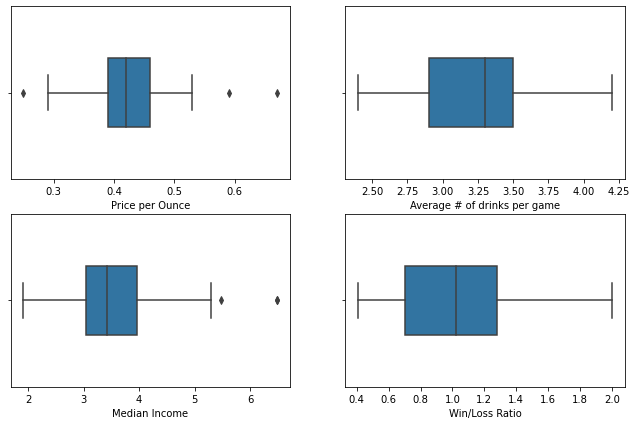

In [14]:
# plotting box and whiskper plot
fig, axes = plt.subplots(2, 2,sharey=False,squeeze=False,figsize=(11,7))

ax = sns.boxplot(x='Price per Ounce' ,data=final_result,
    ax=axes[0, 0],width=0.4,orient='h')
ax = sns.boxplot(x='Average # of drinks per game', data=final_result,
    ax=axes[0, 1],width=0.4,orient='h')
ax = sns.boxplot(x='Median Income' ,data=final_result,
    ax=axes[1, 0],width=0.4,orient='h')
ax = sns.boxplot(x='Win/Loss Ratio' , data=final_result,
    ax=axes[1, 1],width=0.4,orient='h')

The 4 plots above show the distrution of each conresponding data points. The 'Price-per-ounce' and the 'Median Income' plots both appear to shows the least amount of variance around the mean. Although they both show some outliers, how densed the plot looks gives us a sense of consistency. One of our initial questions IS how median Household income affects the price of beer at a city where there is a MLB game/Stadium. It would make more sense to do a scatter plot with 'Price-per-ounce' and the 'Median Income'. This should make predictions more dependable. 

The 'Win/Loss Ratio' and the 'Average # of Drinks per game' plots, in a sense are both similar as well. They vary quite a bit, as evident by the larger width of the box plot. preditions based on these 2 data point might be a little less dependable. 

#### Findings

The r-valued is: 0.27351944841525866


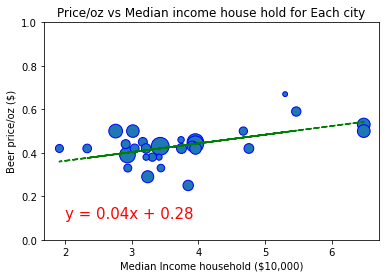

In [18]:
# Testing correlation between income and price of beer per oz

ppo_income = final_result[['Median Income','Price per Ounce','Population']]

# calculate linear regression
data_regress = linregress(ppo_income.iloc[:,0],ppo_income.iloc[:,1])

# unpack the regression 
(slope, intercept, rvalue, pvalue, stderr) = data_regress

# using the regression formula (y = mx + b) pass the unpacked values into a variable
regression_value = ppo_income.iloc[:,0]*slope + intercept
equation = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
# print(equation)

# scatter plot

plt.scatter(ppo_income['Median Income'],ppo_income['Price per Ounce'],s=ppo_income['Population'],edgecolors='b')
plt.plot(ppo_income.iloc[:,0],regression_value,color='green', linestyle='dashed')
plt.annotate(equation,(2,0.1),fontsize=15,color="red")

# labels for plot
plt.title("Price/oz vs Median income house hold for Each city")
plt.xlabel("Median Income household ($10,000)")
plt.ylabel("Beer price/oz ($)")
plt.ylim(0,1)
print(f"The r-valued is: {rvalue**2}")

There appears to be a positive correlation between the median income house hold (city) and the price of beer (per oz) at a MLB game. R-squared value helps us understand that the median household income for a city where a stadium is located can explain about 27% of the difference in price for each beer. Although 27% is not too significant, we are confident in our data's distrubtion to accept the positive correlation. This helps answer or first question, and we do not reject our Null hypothesis. Which is, median income of a city's household affects how much, per ounce, a beer cost at a baseball game.  

There are other factors that, for the interest of time and the absence of extra data, cannot be used support the remaining 73% of our model. Some of these factors may be logistical in nature and how close breweries are to the location.  

#### Analysis - Team's Record vs Beer consumption rate

Create a scatter plot, add a regression line and calculate r-squared value.

The r-valued is: 0.06923949811410202


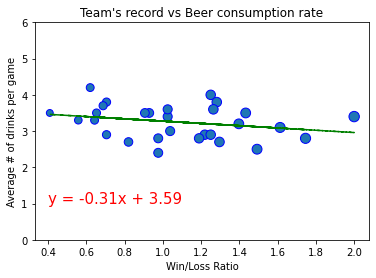

In [19]:
# Testing correlation between Win/Loss ratio and # of drinks per game
record_beer = final_result[['Win/Loss Ratio','Average # of drinks per game']]

# calculate linear regression
data_regress = linregress(record_beer.iloc[:,0],record_beer.iloc[:,1])

# unpack the regression 
(slope, intercept, rvalue, pvalue, stderr) = data_regress

# using the regression formula (y = mx + b) pass the unpacked values into a variable
regression_value = record_beer.iloc[:,0]*slope + intercept
equation = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
# print(equation)

# scatter plot

plt.scatter(record_beer['Win/Loss Ratio'],record_beer['Average # of drinks per game'],s=final_result['Wins'],edgecolors='b')

plt.plot(record_beer.iloc[:,0],regression_value,color='green', linestyle='dashed')
plt.annotate(equation,(0.4,1),fontsize=15,color="red")
# labels for plot
plt.title("Team's record vs Beer consumption rate")
plt.ylabel("Average # of drinks per game")
plt.xlabel("Win/Loss Ratio")
plt.ylim(0,6)
print(f"The r-valued is: {rvalue**2}")

Contrary to our first findings, the above plots a negative correlation between a teams record and the average number of drinks an individual may drink at a game. The slope indicates a negative correlation.  R-squared value helps us understand that a team's record for the 2018 year season only explain about 7% of the difference how much a person may drink at a game. We do not have enough confidence to R-value to accept our null-hypothesis. A team's record does not correlate with how much beer a person drinks at game.  

There are other factors that, for the interest of time and the absence of extra data, that may have a better correlation. Some of these factors may be how much pre-gaming groups of people do before they show up to a game. Also, perhaps fans drink more during playoffs vs regular season; or maybe they drink more during pre-season games.